In [11]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

# Dictionary for overview
models = {}

In [12]:
df = pd.read_csv('./data/mimic_premodel_advanced.csv')

In [13]:
df = df[df.tracheo==0]

In [14]:
df = df.drop(labels='tracheo', axis=1)

In [15]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,PaO2,base_excess,creatinin,hb,pH,...,median_SaO2,std_SaO2,skew_SaO2,kurto_SaO2,minimum_leuko,maximum_leuko,median_leuko,std_leuko,skew_leuko,kurto_leuko
0,1.0,100017.0,258320.0,28.0,8.0,171.0,4.0,0.8,14.3,7.52,...,100.0,0.000000,0.000000,0.000000,9.3,9.3,9.30,1.284338,0.282498,0.424949
1,1.0,100035.0,245719.0,37.0,26.0,39.0,10.0,1.1,14.0,7.41,...,96.0,1.778516,0.104363,-0.201570,17.2,17.2,17.20,1.284338,0.282498,0.424949
2,1.0,100063.0,241782.0,46.0,11.0,365.0,2.0,1.0,14.0,7.39,...,100.0,0.421637,-1.778781,1.406250,8.4,8.4,8.40,1.284338,0.282498,0.424949
3,1.0,100087.0,294404.0,57.0,18.0,143.0,5.0,0.7,15.2,7.47,...,97.0,1.262354,0.717665,0.180998,8.5,8.7,8.60,0.141421,0.282498,0.424949
4,1.0,100141.0,243747.0,40.0,10.0,62.0,6.0,0.8,7.6,7.48,...,95.0,1.414791,0.514331,1.590646,4.9,5.8,5.35,0.636396,0.282498,0.424949


# Scaling and Train/Test-Split

In [16]:
X = df.iloc[:, 3:]
y = df.label

In [17]:
X.head()

,age,numb_diagn,PaO2,base_excess,creatinin,hb,pH,FiO2,PEEP,SaO2,...,median_SaO2,std_SaO2,skew_SaO2,kurto_SaO2,minimum_leuko,maximum_leuko,median_leuko,std_leuko,skew_leuko,kurto_leuko
0,28.0,8.0,171.0,4.0,0.8,14.3,7.52,40.000001,5.0,100.0,...,100.0,0.000000,0.000000,0.000000,9.3,9.3,9.30,1.284338,0.282498,0.424949
1,37.0,26.0,39.0,10.0,1.1,14.0,7.41,70.000000,5.0,95.0,...,96.0,1.778516,0.104363,-0.201570,17.2,17.2,17.20,1.284338,0.282498,0.424949
2,46.0,11.0,365.0,2.0,1.0,14.0,7.39,50.000000,0.0,100.0,...,100.0,0.421637,-1.778781,1.406250,8.4,8.4,8.40,1.284338,0.282498,0.424949
3,57.0,18.0,143.0,5.0,0.7,15.2,7.47,30.000000,5.0,97.0,...,97.0,1.262354,0.717665,0.180998,8.5,8.7,8.60,0.141421,0.282498,0.424949
4,40.0,10.0,62.0,6.0,0.8,7.6,7.48,50.000000,2.0,95.0,...,95.0,1.414791,0.514331,1.590646,4.9,5.8,5.35,0.636396,0.282498,0.424949


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3744 samples.
Testing set has 1248 samples.


In [19]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Functions

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Logistic Regression

## Hyperparameter by default

In [21]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [22]:
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.50      0.15      0.23       363
         1.0       0.73      0.94      0.82       885

    accuracy                           0.71      1248
   macro avg       0.62      0.54      0.52      1248
weighted avg       0.66      0.71      0.65      1248

F-Beta-Score(0.5) =  0.76


Confusion matrix, without normalization
[[ 53 310]
 [ 52 833]]


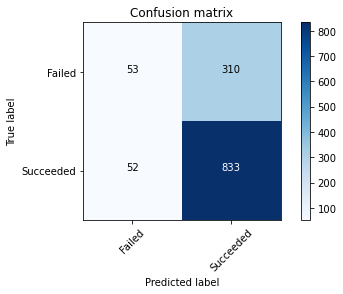

In [23]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

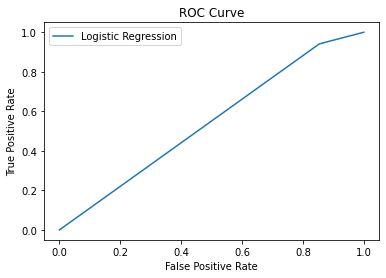

AUC(logReg)= 0.64


In [24]:
# Plot the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_prob = lr.predict_proba(X_test)
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")

In [25]:
models['logReg_simple'] = [precision_score(y_test, y_pred_lr),
                    fbeta_score(y_test, y_pred_lr, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr)]

## Hyperparameter tuning

In [26]:
# Hyperparameter grid for RandomSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [100, 10, 1, 0.1, 0.01] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = fhalf_scorer, cv = c, 
                        n_iter = 100, verbose = 1, random_state=rs)

# Fit 
lr_rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=1)

In [27]:
lr_rs.best_params_

{'penalty': 'l2', 'C': 1}

In [28]:
# Hyperparameter grid for GridSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [3, 2, 1 , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_gs = GridSearchCV(estimator, param_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
lr_gs.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 177 out of 192 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    1.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2,
                               0.1, 0.09, 0.08, 0.07, 0.06],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [29]:
lr_gs.best_params_

{'C': 0.7, 'penalty': 'l2'}

In [30]:
best_model_lr_gs = lr_gs.best_estimator_

In [31]:
y_pred_lr_best = best_model_lr_gs.predict(X_test)
print(classification_report(y_test, y_pred_lr_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.50      0.15      0.23       363
         1.0       0.73      0.94      0.82       885

    accuracy                           0.71      1248
   macro avg       0.62      0.54      0.52      1248
weighted avg       0.66      0.71      0.65      1248

F-Beta-Score(0.5) =  0.76


Confusion matrix, without normalization
[[ 53 310]
 [ 52 833]]


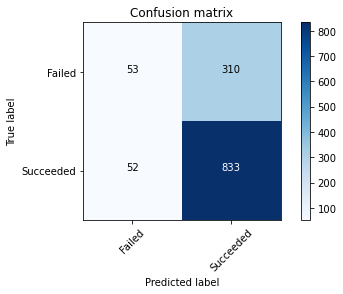

In [32]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

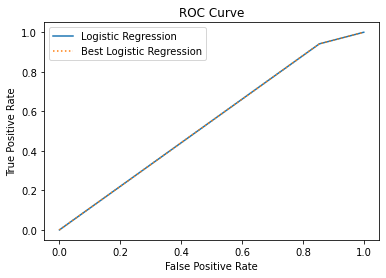

AUC(logReg)= 0.64
AUC(BestlogReg)= 0.64


In [33]:
# Plot the ROC curve
fpr_lr_best, tpr_lr_best, thresholds_lr_best = roc_curve(y_test, y_pred_lr_best)
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.plot(fpr_lr_best, tpr_lr_best, linestyle=':', label='Best Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_best_prob = best_model_lr_gs.predict_proba(X_test)
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")
print(f"AUC(BestlogReg)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")

In [34]:
models['logReg_best'] = [precision_score(y_test, y_pred_lr_best),
                    fbeta_score(y_test, y_pred_lr_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_best_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr_best)]

# Random Forest

##  Advanced Model

In [35]:
rf_clf_base = RandomForestClassifier(random_state=rs)
rf_clf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
y_pred_rf_clf_base = rf_clf_base.predict(X_test)

### Evaluate Advanced Model

In [37]:
print(classification_report(y_test, y_pred_rf_clf_base))
print(confusion_matrix(y_test, y_pred_rf_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.63      0.20      0.30       363
         1.0       0.74      0.95      0.83       885

    accuracy                           0.73      1248
   macro avg       0.69      0.58      0.57      1248
weighted avg       0.71      0.73      0.68      1248

[[ 73 290]
 [ 43 842]]
F-Beta-Score(0.5) =  0.78


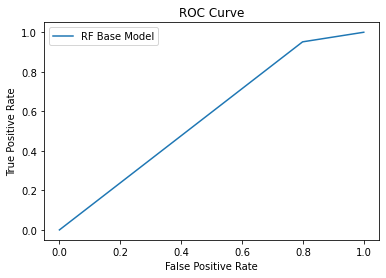

AUC(BaseModel)= 0.65


In [38]:
# ROC Curve Base Model and Dummy
fpr_rf_bm, tpr_rf_bm, thresholds_rf_bm = roc_curve(y_test, y_pred_rf_clf_base)
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_base = rf_clf_base.predict_proba(X_test)
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")

In [39]:
models['RF_simple'] = [precision_score(y_test, y_pred_rf_clf_base),
                    fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_clf_base[:,1]),
                    accuracy_score(y_test, y_pred_rf_clf_base)]

In [40]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_clf_base.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Random Search

In [41]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [43]:
# Random search of parameters, using 3 fold cross validation 
rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, scoring=fhalf_scorer, 
                               n_iter = 100, cv = c_strat, random_state=rs, n_jobs = -1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5))

In [44]:
rf_random.best_params_

{'n_estimators': 944,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

## Grid Search

In [45]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [500, 1000, 1500]
}

In [46]:
# Instantiate the grid search model
grid_search_rf_adv = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1)

# Fit the grid search to the data
grid_search_rf_adv.fit(X_train, y_train)

# Y Predict
y_pred_rf_adv = grid_search_rf_adv.predict(X_test)

In [47]:
grid_search_rf_adv.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 500}

In [48]:
best_model_rf_adv = grid_search_rf_adv.best_estimator_

### Evaluate Grid Search

In [49]:
print(classification_report(y_test, y_pred_rf_adv))
print(confusion_matrix(y_test, y_pred_rf_adv))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_adv, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.68      0.22      0.33       363
         1.0       0.75      0.96      0.84       885

    accuracy                           0.74      1248
   macro avg       0.71      0.59      0.59      1248
weighted avg       0.73      0.74      0.69      1248

[[ 80 283]
 [ 38 847]]
F-Beta-Score(0.5) =  0.78


Confusion matrix, without normalization
[[ 80 283]
 [ 38 847]]


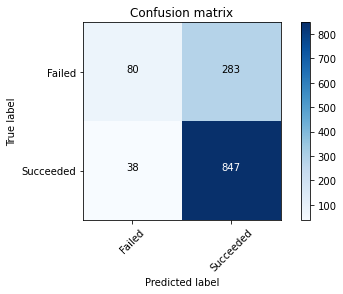

In [50]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rf_adv)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

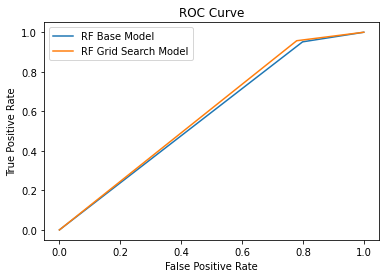

AUC(BaseModel)= 0.65
AUC(GridSearch)= 0.66


In [51]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_rf_gs, tpr_rf_gs, thresholds_rf_gs = roc_curve(y_test, y_pred_rf_adv)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.plot(fpr_rf_gs, tpr_rf_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_adv = best_model_rf_adv.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_rf_adv[:,1]):.2f}")

In [52]:
models['RF_best'] = [precision_score(y_test, y_pred_rf_adv),
                    fbeta_score(y_test, y_pred_rf_adv, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_adv[:,1]),
                    accuracy_score(y_test, y_pred_rf_adv)]

# AdaBoost

In [53]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         0.0       0.51      0.27      0.35       363
         1.0       0.75      0.89      0.82       885

    accuracy                           0.71      1248
   macro avg       0.63      0.58      0.58      1248
weighted avg       0.68      0.71      0.68      1248



In [54]:
fbeta_score(y_test, y_pred_ada, beta=0.5)

0.7741240947347817

Text(0.5, 1.0, 'Confusion matrix')

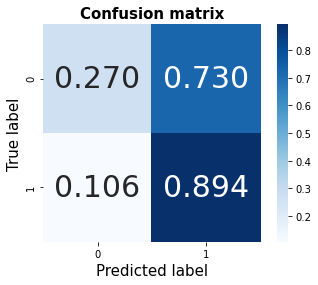

In [55]:
cm = confusion_matrix(y_test, ada.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

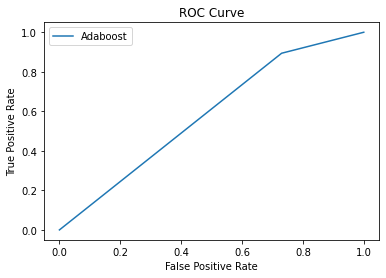

AUC(Adaboost)= 0.65


In [56]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

In [57]:
models['Ada_simple'] = [precision_score(y_test, y_pred_ada),
                    fbeta_score(y_test, y_pred_ada, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob[:,1]),
                    accuracy_score(y_test, y_pred_ada)]

## Randomsearch

In [58]:
ada_grid = dict()
ada_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
ada_grid['n_estimators'] = [100, 200, 250, 300, 500]

model = AdaBoostClassifier()
grid = ada_grid
    
# run randomized search and optimize for fhalf_scorer
ada_rdm = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs, cv=c)
search = ada_rdm.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


In [59]:
print(search.best_params_)

{'n_estimators': 200, 'learning_rate': 0.2}


In [60]:
y_pred_ada_rdm = ada_rdm.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred_ada_rdm))

              precision    recall  f1-score   support

         0.0       0.61      0.23      0.33       363
         1.0       0.75      0.94      0.83       885

    accuracy                           0.73      1248
   macro avg       0.68      0.58      0.58      1248
weighted avg       0.71      0.73      0.69      1248



In [62]:
fbeta_score(y_test, y_pred_ada_rdm, beta=0.5)

0.780400974330148

Text(0.5, 1.0, 'Confusion matrix')

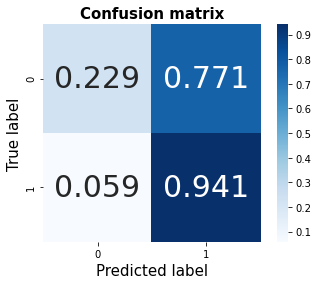

In [63]:
cm = confusion_matrix(y_test, ada_rdm.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

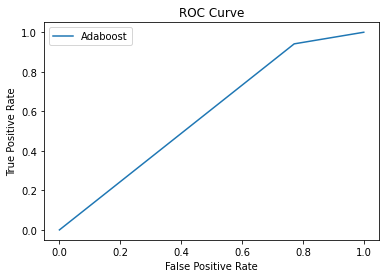

AUC(Adaboost)= 0.66


In [64]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_rdm)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_rdm.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

## Gridsearch

In [65]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[200],                
              'learning_rate':[0.2, 0.15, 0.25,],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = fhalf_scorer

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(ada, parameters,scorer, cv=c) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_ada = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_ada)


Unoptimized model
------
Accuracy score on testing data: 0.6178
F-score on testing data: 0.7365

Optimized Model
------
Final accuracy score on the testing data: 0.7300
Final F-score on the testing data: 0.7791
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.25, n_estimators=200)


In [66]:
ada_grid = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.25, n_estimators=200)
ada_grid.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.25, n_estimators=200)

In [67]:
y_pred_ada_grid = ada_grid.predict(X_test)

In [68]:
print(classification_report(y_test, y_pred_ada_grid))

              precision    recall  f1-score   support

         0.0       0.59      0.23      0.34       363
         1.0       0.75      0.93      0.83       885

    accuracy                           0.73      1248
   macro avg       0.67      0.58      0.58      1248
weighted avg       0.70      0.73      0.69      1248



In [69]:
fbeta_score(y_test, y_pred_ada_grid, beta=0.5)

0.7790982833427655

Text(0.5, 1.0, 'Confusion matrix')

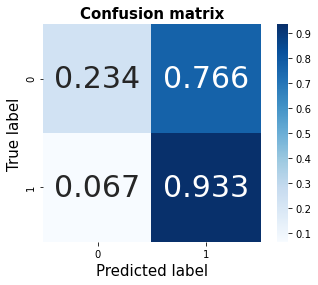

In [70]:
cm = confusion_matrix(y_test, ada_grid.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

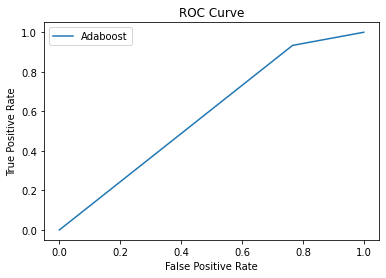

AUC(Adaboost)= 0.65


In [71]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_grid)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_grid.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

In [72]:
models['Ada_best'] = [precision_score(y_test, y_pred_ada_grid),
                    fbeta_score(y_test, y_pred_ada_grid, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob[:,1]),
                    accuracy_score(y_test, y_pred_ada_grid)]

# XGBoost

In [73]:
# instanciate classifier, fit model
xgboost = XGBClassifier(random_state=rs)
xgboost.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [74]:
y_pred_xgb = xgboost.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.64      0.23      0.34       363
         1.0       0.75      0.95      0.84       885

    accuracy                           0.74      1248
   macro avg       0.70      0.59      0.59      1248
weighted avg       0.72      0.74      0.69      1248



In [76]:
fbeta_score(y_test, y_pred_xgb, beta=0.5)

0.7833239857917368

Text(0.5, 1.0, 'Confusion matrix')

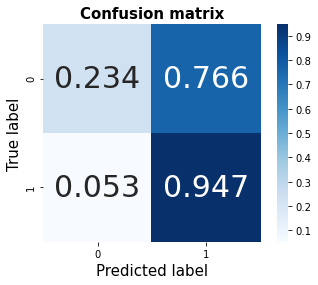

In [77]:
cm = confusion_matrix(y_test, xgboost.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

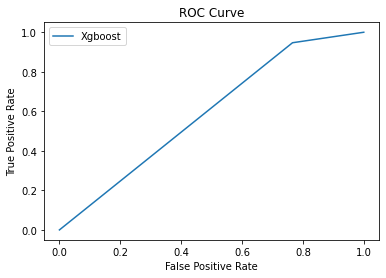

AUC(Xgboost)= 0.67


In [78]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = xgboost.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

In [79]:
models['XGB_simple'] = [precision_score(y_test, y_pred_xgb),
                    fbeta_score(y_test, y_pred_xgb, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob[:,1]),
                    accuracy_score(y_test, y_pred_xgb)]

## random search

In [80]:
xgb_grid = dict()
xgb_grid['max_depth'] = [2, 3, 4, 5, 6]
xgb_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
xgb_grid['gamma'] = [0,0.1,0.2,0.3,0.4,0.5]

model = XGBClassifier()
grid = xgb_grid
    
# run randomized search and optimize for fhalf_scorer
clf = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs,cv=c)
search = clf.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   36.9s finished


In [81]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.67      0.21      0.33       363
         1.0       0.75      0.96      0.84       885

    accuracy                           0.74      1248
   macro avg       0.71      0.59      0.58      1248
weighted avg       0.73      0.74      0.69      1248



In [82]:
print(search.best_params_)

{'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1}


best result: {'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}

In [83]:
y_pred_xgb_rdm = clf.predict(X_test)

In [84]:
fbeta_score(y_test, y_pred_xgb_rdm, beta=0.5)

0.7823757620543136

Text(0.5, 1.0, 'Confusion matrix')

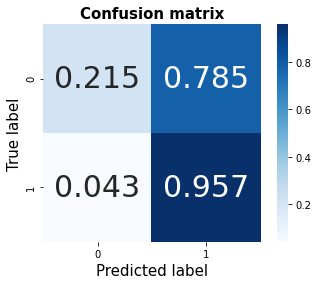

In [85]:
cm = confusion_matrix(y_test, clf.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

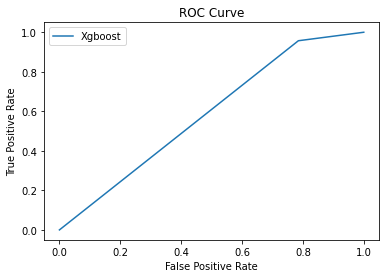

AUC(Xgboost)= 0.67


In [86]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_lr = roc_curve(y_test, y_pred_xgb_rdm)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = clf.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

## Gridsearch

In [87]:
{'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.02, 0.01, 0.015],
    'gamma': [0.3, 0.35, 0.25],}

optimal_params = GridSearchCV(
    estimator= XGBClassifier(), cv=c,
    param_grid=param_grid,
     scoring = fhalf_scorer)## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 0.3, 'learning_rate': 0.02, 'max_depth': 4}


{'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 4}

In [88]:
y_pred_xgb_grid = optimal_params.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred_xgb_grid))

              precision    recall  f1-score   support

         0.0       0.68      0.21      0.32       363
         1.0       0.75      0.96      0.84       885

    accuracy                           0.74      1248
   macro avg       0.72      0.58      0.58      1248
weighted avg       0.73      0.74      0.69      1248



In [90]:
fbeta_score(y_test, y_pred_xgb_grid, beta=0.5)

0.7822565801582919

Text(0.5, 1.0, 'Confusion matrix')

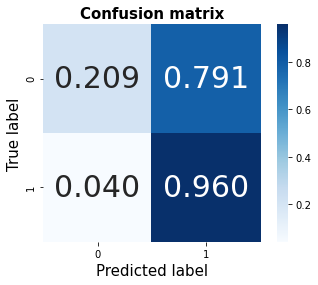

In [91]:
cm = confusion_matrix(y_test, optimal_params.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

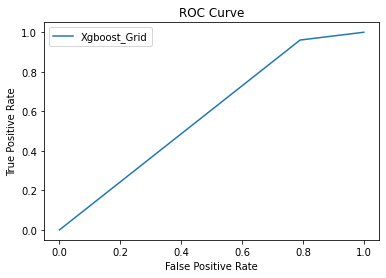

AUC(Xgboost)= 0.68


In [92]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_grid)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost_Grid')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = optimal_params.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

In [93]:
models['XGB_best'] = [precision_score(y_test, y_pred_xgb_grid),
                    fbeta_score(y_test, y_pred_xgb_grid, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob[:,1]),
                    accuracy_score(y_test, y_pred_xgb_grid)]

# SVM Classifier

## Simple Model

In [94]:
svc_model = SVC(C=1, kernel='rbf', probability=True, random_state=rs)
svc = svc_model.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [95]:
print(classification_report(y_test, y_pred_svc))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.65      0.12      0.21       363
         1.0       0.73      0.97      0.83       885

    accuracy                           0.73      1248
   macro avg       0.69      0.55      0.52      1248
weighted avg       0.71      0.73      0.65      1248

F-Beta-Score(0.5) =  0.77


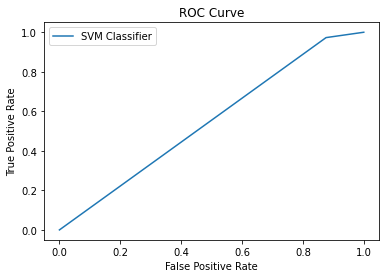

AUC (SVC)= 0.67


In [96]:
# Plot the ROC curve
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_svc)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_svc, tpr_svc, linestyle='-', label='SVM Classifier') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob = svc.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}")

In [97]:
models['SVC_simple'] = [precision_score(y_test, y_pred_svc),
                    fbeta_score(y_test, y_pred_svc, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob[:,1]),
                    accuracy_score(y_test, y_pred_svc)]

## Tuning with Gridsearch

In [98]:
grid_svc = {'C': [0.1,1, 10, 50, 100],
             #'kernel': ['linear', 'rbf', 'poly','sigmoid'],
             'kernel': ['linear', 'rbf'],
             'gamma' : [1, 0.1, 0.01, 0.001]
             }

In [99]:
svc_grid = GridSearchCV(estimator= SVC(), 
                        param_grid=grid_svc, 
                        cv=c, 
                        verbose=2, n_jobs=-1,
                        scoring=fhalf_scorer)

In [100]:
svc_grid.fit(X_train, y_train)
y_pred_svc_grid = svc_grid.predict(X_test)
svc_grid.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 175.0min finished


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [101]:
svc_bestmodel = SVC(C=100, kernel='rbf', probability=True, gamma=0.001, random_state=rs)
svc_best = svc_bestmodel.fit(X_train, y_train)
y_pred_svc_best = svc_best.predict(X_test)

In [102]:
print(classification_report(y_test, y_pred_svc_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.53      0.18      0.27       363
         1.0       0.74      0.94      0.82       885

    accuracy                           0.72      1248
   macro avg       0.63      0.56      0.55      1248
weighted avg       0.68      0.72      0.66      1248

F-Beta-Score(0.5) =  0.77


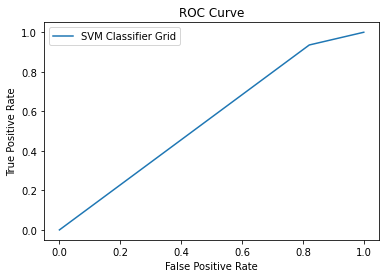

AUC (SVC)= 0.67
AUC (SVC_best)= 0.66


In [103]:
# Plot the ROC curve
fpr_svc_grid, tpr_svc_grid, thresholds_svc_grid = roc_curve(y_test, y_pred_svc_best)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_svc_grid, tpr_svc_grid, linestyle='-', label='SVM Classifier Grid') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob_best = svc_best.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}")
print(f"AUC (SVC_best)= {roc_auc_score(y_test, y_pred_svc_prob_best[:,1]):.2f}")

In [104]:
models['SVC_grid'] = [precision_score(y_test, y_pred_svc_best),
                    fbeta_score(y_test, y_pred_svc_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob_best[:,1]),
                    accuracy_score(y_test, y_pred_svc_best)]

# kNN

## Simple kNN

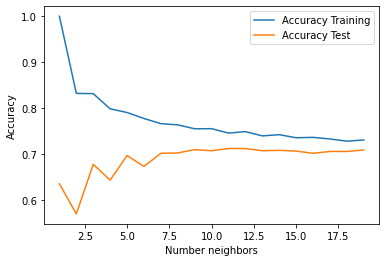

In [105]:
train_accuracy = []
test_accuracy = []
train_beta = []
test_beta = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 20)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_beta.append(fbeta_score(y_test, y_pred, beta=0.5))
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend();

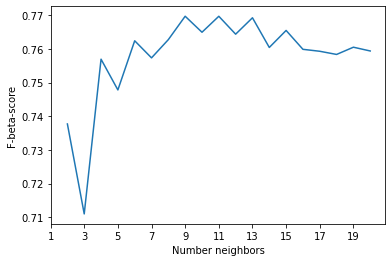

In [106]:
plt.plot(neighbor_settings, train_beta)
plt.ylabel('F-beta-score')
plt.xlabel('Number neighbors')
plt.xticks(ticks=list(range(0,20,2)) ,labels=list(range(1,20,2)));

We take 12 neighbours as best value, for the first simple model.

In [107]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)
y_pred_knn= knn.predict(X_test)

In [108]:
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_knn, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.51      0.21      0.30       363
         1.0       0.74      0.92      0.82       885

    accuracy                           0.71      1248
   macro avg       0.62      0.57      0.56      1248
weighted avg       0.67      0.71      0.67      1248

[[ 78 285]
 [ 75 810]]
F-Beta-Score(0.5) =  0.77


In [109]:
y_pred_knn_prob = clf.predict_proba(X_test)


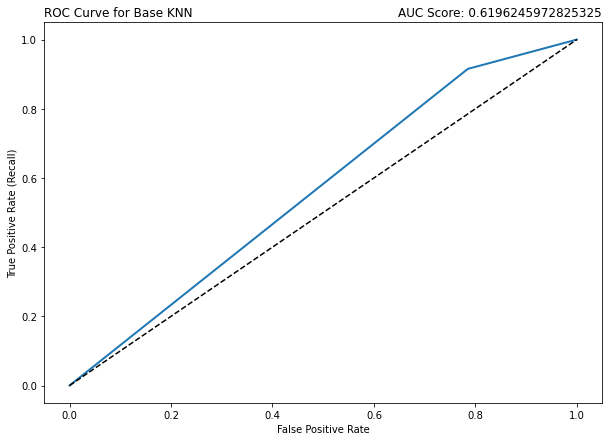

In [110]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
auc_score = roc_auc_score(y_test, y_pred_knn_prob[:,1])

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base KNN', loc='left')
plt.title(f'AUC Score: {auc_score}', loc='right');

In [111]:
models['knn_simple'] = [precision_score(y_test, y_pred_knn),
                    fbeta_score(y_test, y_pred_knn, beta=0.5),
                    roc_auc_score(y_test, y_pred_knn_prob[:,1]),
                    accuracy_score(y_test, y_pred_knn)]

## Optimize Model

In [112]:
grid_knn = {'n_neighbors' : list(range(1,30)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,20)),
             'metric' : ['euclidean','minkowski','manhattan']}

In [113]:
knn_grid_mod = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid_knn, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        scoring=fhalf_scorer)
knn_grid_mod.fit(X_train, y_train)
y_pred = knn_grid_mod.predict(X_test)


In [114]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.48      0.16      0.24       363
         1.0       0.73      0.93      0.82       885

    accuracy                           0.70      1248
   macro avg       0.60      0.54      0.53      1248
weighted avg       0.66      0.70      0.65      1248

[[ 58 305]
 [ 64 821]]
F-Beta-Score(0.5) =  0.76


In [115]:
knn_grid_mod.best_params_

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 10,
 'weights': 'distance'}

In [116]:
y_pred_prob = knn_grid_mod.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}')

ROC-AUC-Score = 0.60


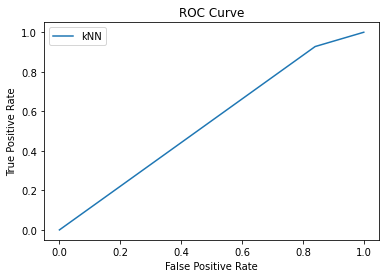

AUC(kNN)= 0.60


In [119]:
# Plot the ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred)
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='kNN') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob = knn_grid_mod.predict_proba(X_test)
print(f"AUC(kNN)= {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}")

Confusion matrix, without normalization
[[ 58 305]
 [ 64 821]]


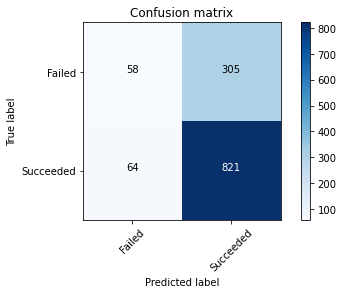

In [120]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [121]:
models['knn_best'] = [precision_score(y_test, y_pred),
                    fbeta_score(y_test, y_pred, beta=0.5),
                    roc_auc_score(y_test, y_pred_prob[:,1]),
                    accuracy_score(y_test, y_pred)]

# Naive Bayes

## Hyperparameter by default

In [122]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

In [123]:
print(classification_report(y_test, y_pred_gnb))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.38      0.60      0.46       363
         1.0       0.78      0.59      0.67       885

    accuracy                           0.59      1248
   macro avg       0.58      0.59      0.57      1248
weighted avg       0.66      0.59      0.61      1248

F-Beta-Score(0.5) =  0.73


Confusion matrix, without normalization
[[216 147]
 [360 525]]


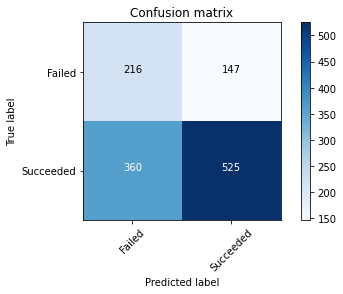

In [124]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

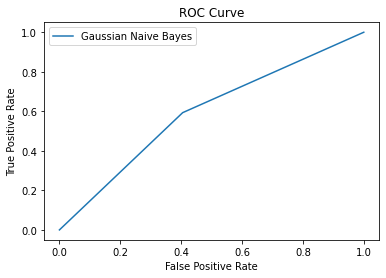

AUC(GNB)= 0.61


In [125]:
# Plot the ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_gnb)
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Gaussian Naive Bayes') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob = gnb.predict_proba(X_test)
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")

In [126]:
models['GNB_simple'] = [precision_score(y_test, y_pred_gnb),
                    fbeta_score(y_test, y_pred_gnb, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_prob[:,1]),
                    accuracy_score(y_test, y_pred_gnb)]

## Hyperparameter tuning

In [127]:
# Hyperparameter grid for GridSearch for Naive Bayes
params_grid = {'var_smoothing': np.logspace(1,-9, num=1000)}

# Estimator for use in gridSearch
estimator = GaussianNB()

# Create the gridSearch model
gnb_gs = GridSearchCV(estimator, params_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
gnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2927 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   10.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+01, 9.77214697e+00, 9.54948564e+00, 9.33189772e+00,
       9.11926760e+00, 8.91148232e+00, 8.70843150e+00, 8.51000725e+00,
       8.31610415e+00, 8.12661920e+00, 7.94145172e+00, 7.76050334e+00,
       7.58367791e+00, 7.41088152e...
       1.54949504e-09, 1.51418933e-09, 1.47968806e-09, 1.44597292e-09,
       1.41302599e-09, 1.38082977e-09, 1.34936714e-09, 1.31862140e-09,
       1.28857621e-09, 1.25921561e-09, 1.23052400e-09, 1.20248614e-09,
       1.17508713e-09, 1.14831241e-09, 1.12214777e-09, 1.09657929e-09,
       1.07159340e-09, 1.04717682e-09, 1.02331658e-09, 1.00000000e-09])},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [128]:
gnb_gs.best_params_

{'var_smoothing': 0.6148777653810024}

In [129]:
best_model_gnb_gs = gnb_gs.best_estimator_

In [130]:
y_pred_gnb_best = best_model_gnb_gs.predict(X_test)
print(classification_report(y_test, y_pred_gnb_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.49      0.14      0.22       363
         1.0       0.73      0.94      0.82       885

    accuracy                           0.71      1248
   macro avg       0.61      0.54      0.52      1248
weighted avg       0.66      0.71      0.65      1248

F-Beta-Score(0.5) =  0.76


Confusion matrix, without normalization
[[ 52 311]
 [ 54 831]]


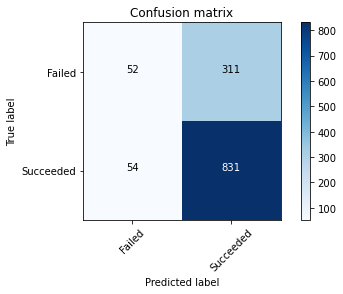

In [131]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

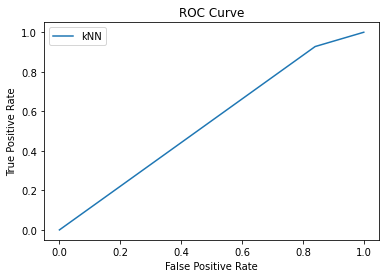

AUC(kNN)= 0.60


In [136]:
# Plot the ROC curve
fpr_knn_grid, tpr_knn_grid, thresholds_grid= roc_curve(y_test, y_pred)
plt.plot(fpr_knn_grid, tpr_knn_grid, linestyle='-', label='kNN')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_prob =knn_grid_mod.predict_proba(X_test)
print(f"AUC(kNN)= {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}")

In [137]:
models['GNB_best'] = [precision_score(y_test, y_pred_gnb_best),
                    fbeta_score(y_test, y_pred_gnb_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]),
                    accuracy_score(y_test, y_pred_gnb_best)]

# Overview

In [138]:
overview = pd.DataFrame.from_dict(models, orient='index')
overview.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
overview

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
logReg_simple,0.728784,0.763240,0.637273,0.709936
logReg_best,0.728784,0.763240,0.637425,0.709936
RF_simple,0.743816,0.777757,0.653598,0.733173
RF_best,0.749558,0.783534,0.662186,0.742788
Ada_simple,0.749053,0.774124,0.651605,0.712340
Ada_best,0.748188,0.779098,0.652142,0.729968
XGB_simple,0.750896,0.783324,0.669586,0.739583
XGB_best,0.747581,0.782257,0.677826,0.741987
SVC_simple,0.730280,0.768613,0.665222,0.725962
SVC_grid,0.735346,0.768232,0.658950,0.715545


In [142]:
bestmodels = overview.drop(['logReg_simple', 'RF_simple', 'Ada_simple', 'XGB_simple',
                            'SVC_simple', 'knn_simple', 'GNB_simple'],axis=0)

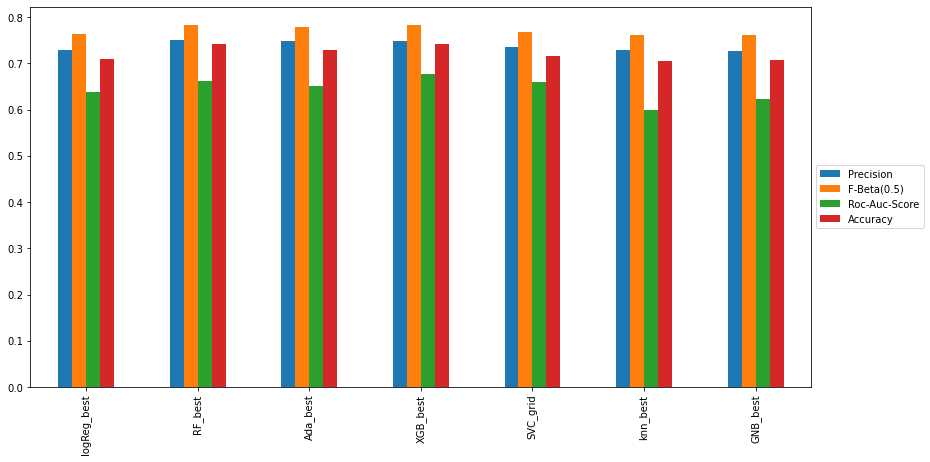

In [147]:
bestmodels.plot(kind='bar', figsize=(14,7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

# Feature Importance

##### Set the color palette

In [144]:
# Explore color codes
blue_1 = '#4fbbd2'
blue_2 = '#0085a0'
blue_3 = '#173f6d'
green = '#21a8a4'
red = '#f27050'
orange = '#ffa733'

# List of colors 
colors = [blue_3, blue_2, blue_1, green, orange, red]
current_palette = sns.color_palette(colors)

##### Prepare the KNN metric

##### Initialize our best fitted Classifiers 

In [154]:
ABC = ada.feature_importances_
XGBC = xgboost.feature_importances_
RDMC = rf_clf_base.feature_importances_
LOGC = abs(best_model_lr_gs.coef_[0])


# List of Tree-based Classifiers used for feature Selection
best_clf = [ABC, XGBC, RDMC, LOGC]

# List of Classifier Names
name_clf = ["ABC", "XGBC", "RDMC", "LOGC"]

##### make a function that gives us only the first 25 best features

In [155]:
def feature_selection(results_dict, tree_clf, name_clf, n=25):
    
    # n is the number of Features + classifier added to the results dictionary (default=20)
    # and printed during process for each classifier
    # if n=None all Features + classifier are added and printed
    
    count = 0
    
    for classifier in tree_clf:
        
        indices = np.argsort(classifier)[::-1]
        feature_name = X.columns[indices]
    
        # Write first n Ranks to dictionary results_dict as 
        # "name_clf: (feature_name, importance)", default is n=20
        results_dict[name_clf[count]] = list(zip(feature_name[0:n], classifier[indices][0:n]))     
        
        count +=1
    
        
    return results_dict

##### Create dataframes for visualization

In [156]:
# Create Dictionary for Feature Selection Results
results_fs = {}

# Use feature_selection function 
feature_selection(results_fs, best_clf, name_clf)

# Making Dataframes from results_fs Dictionary
log_dataframe = pd.DataFrame(results_fs["LOGC"]).rename(columns={0:"Features", 1:"importance value"})
rfc_dataframe = pd.DataFrame(results_fs["RDMC"]).rename(columns={0:"Features", 1:"importance value"})
abc_dataframe = pd.DataFrame(results_fs["ABC"]).rename(columns={0:"Features", 1:"importance value"})
xgbc_dataframe = pd.DataFrame(results_fs["XGBC"]).rename(columns={0:"Features", 1:"importance value"})

##### make the visualization

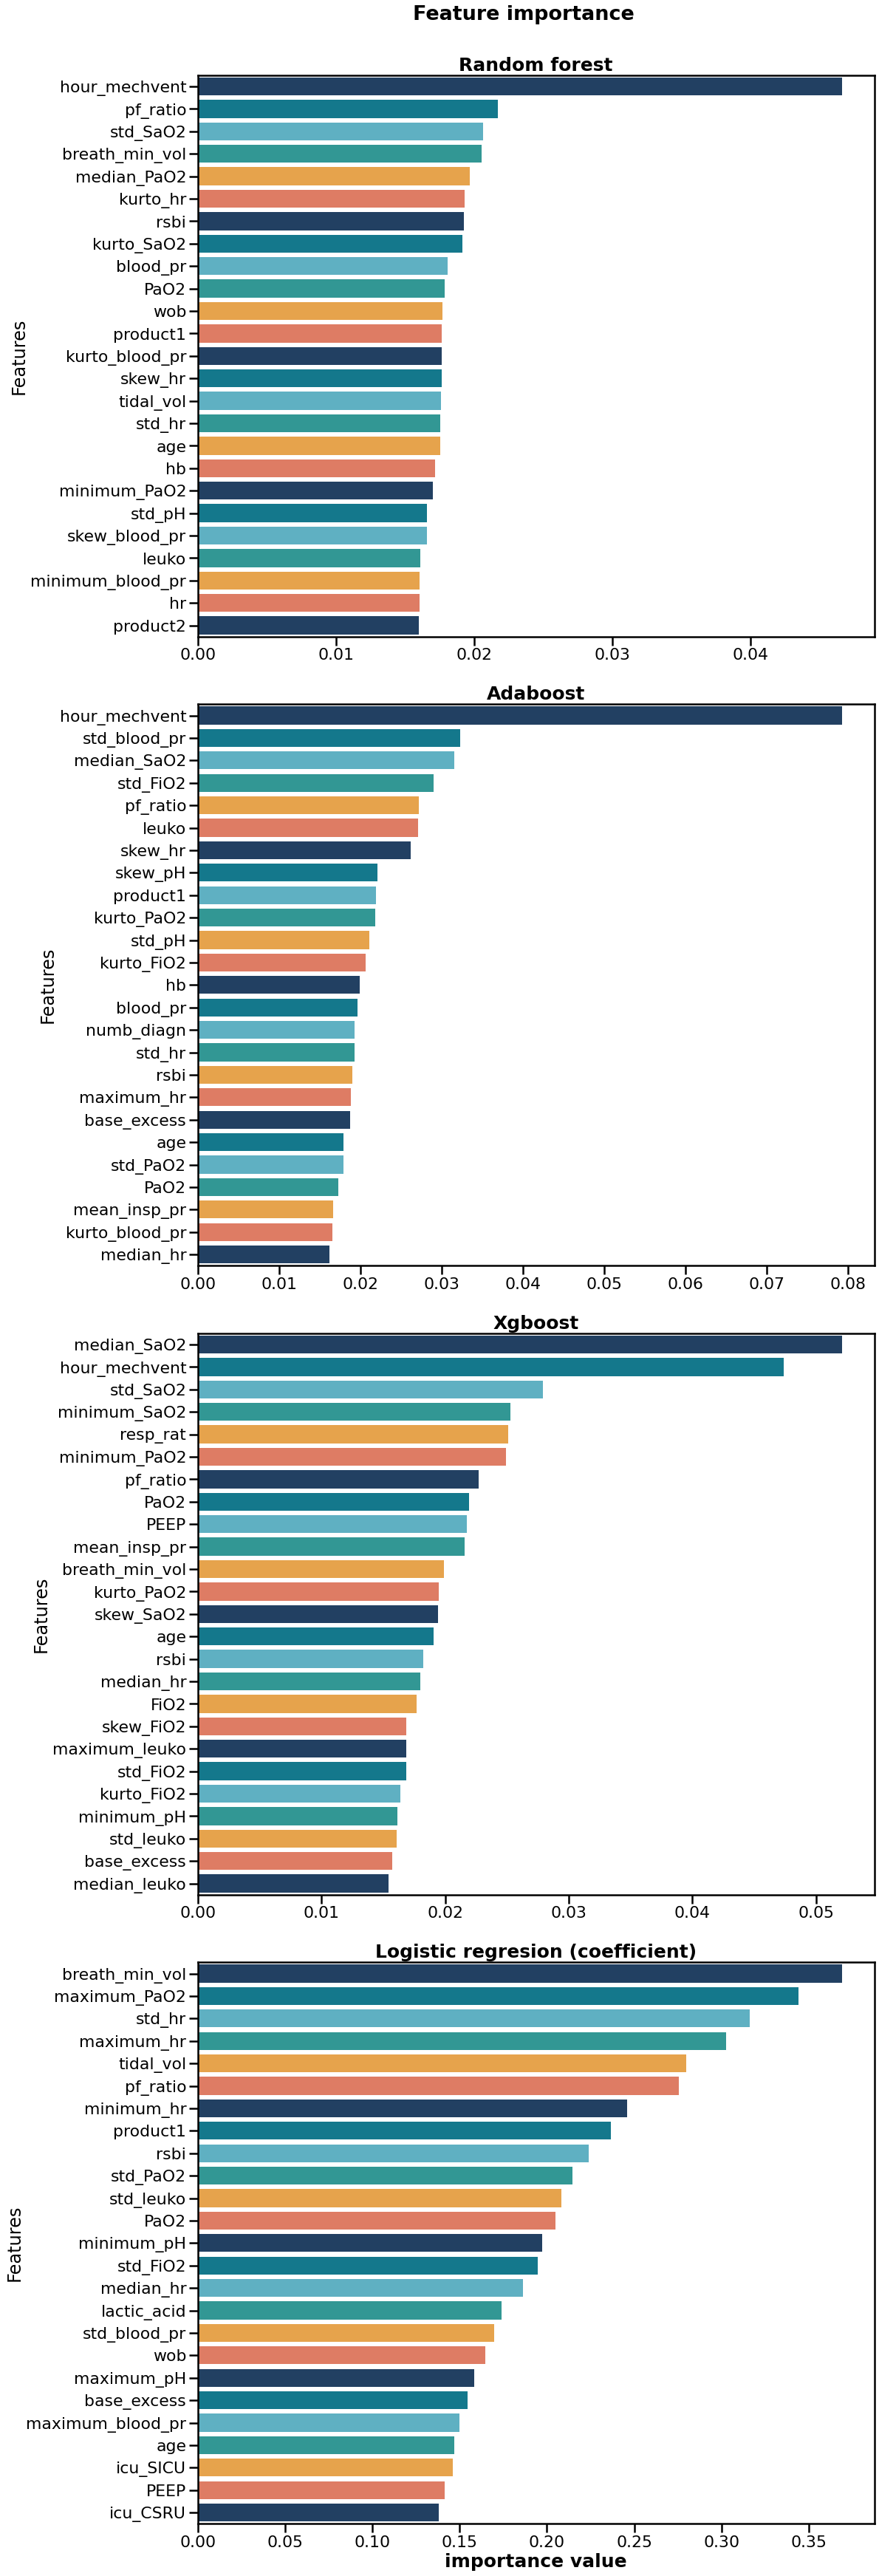

In [161]:
# Plots for feature Selection
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 49))
f.suptitle("Feature importance",fontsize=27, fontweight = 'bold', y= 0.99)
f.tight_layout(pad=2.0)
sns.set_context("poster")

sns.barplot(y="Features", x="importance value", data=rfc_dataframe, ax=ax1, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=abc_dataframe, ax=ax2, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=xgbc_dataframe, ax=ax3, palette=current_palette) 
sns.barplot(y="Features", x="importance value", data=log_dataframe, ax=ax4, palette=current_palette)

ax1.set_title("Random forest", fontsize=25, fontweight="bold")
ax2.set_title("Adaboost", fontsize=25, fontweight="bold")
ax3.set_title("Xgboost", fontsize=25, fontweight="bold")
ax4.set_title("Logistic regresion (coefficient)", fontsize=25, fontweight="bold")

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel("importance value", fontsize=25, fontweight="bold");

# Best Models with only the most important features

In [162]:
def feature_redu (dataframe, number_features, estimator):
    liste = list(dataframe.Features.loc[:(number_features-1)].values)
    X1 = df[liste]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.25, random_state=rs, stratify=y)
    scaler = preprocessing.StandardScaler().fit(X_train1)
    X_train1 = scaler.transform(X_train1)
    X_test1 = scaler.transform(X_test1)
    
    clf_reduced = estimator
    clf_reduced.fit(X_train1, y_train1)
    y_pred_clf_reduced = clf_reduced.predict(X_test1)
    #print(classification_report(y_test1, y_pred_clf_reduced))
    #print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test1, y_pred_clf_reduced, beta=0.5 ):.2f}')
    y_pred_clf_prob_reduced = clf_reduced.predict_proba(X_test1)
    #print(f"AUC= {roc_auc_score(y_test1, y_pred_clf_prob_reduced[:,1]):.2f}")
    
    return [precision_score(y_test1, y_pred_clf_reduced),
            fbeta_score(y_test1, y_pred_clf_reduced, beta=0.5),
            roc_auc_score(y_test1, y_pred_clf_prob_reduced[:,1]),
            accuracy_score(y_test1, y_pred_clf_reduced)]
    

In [163]:
def first_feature (diction, dataframe, number, estimator):
    
    for i in range(number):
        diction[i+1] = feature_redu(dataframe, i+1, estimator)
    ubersicht = pd.DataFrame.from_dict(diction, orient='index')
    ubersicht.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
    return ubersicht.sort_values(by='F-Beta(0.5)', ascending = False)
    

In [164]:
xgb = {}
ubersicht_xgb = first_feature(xgb, xgbc_dataframe, 20, XGBClassifier())
ubersicht_xgb.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
20,0.752000,0.785515,0.661456,0.745192
17,0.752000,0.785515,0.656556,0.745192
5,0.750883,0.785147,0.640832,0.745994
10,0.750444,0.784004,0.672246,0.742788
3,0.749779,0.783879,0.637072,0.743590


In [165]:
ada = {}
ubersicht_ada = first_feature(ada, abc_dataframe, 20, AdaBoostClassifier())
ubersicht_ada.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
3,0.750446,0.783547,0.622353,0.741186
11,0.750680,0.781574,0.649971,0.733974
12,0.750680,0.781574,0.649971,0.733974
20,0.752778,0.780980,0.646230,0.728365
19,0.750916,0.780506,0.635554,0.729968


In [166]:
logReg = {}
ubersicht_logReg = first_feature(logReg, log_dataframe, 20, LogisticRegression(penalty= 'l2', C= 0.1))
ubersicht_logReg.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
19,0.717755,0.756933,0.609139,0.707532
17,0.716060,0.756516,0.613482,0.709135
16,0.716060,0.756516,0.613304,0.709135
15,0.715581,0.756493,0.607038,0.709936
14,0.715226,0.756310,0.602851,0.709936


In [168]:
RF = {}
ubersicht_RF = first_feature(RF, rfc_dataframe, 20, RandomForestClassifier(bootstrap= False, max_depth= 40, max_features= 'auto', min_samples_leaf= 3,
                                     min_samples_split= 3, n_estimators= 500, random_state=rs))
ubersicht_RF.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
16,0.747748,0.779343,0.635363,0.731571
17,0.746631,0.778527,0.654388,0.730769
15,0.747064,0.778280,0.636284,0.729167
7,0.747502,0.778030,0.639178,0.727564
20,0.745961,0.777944,0.643272,0.729968


In [169]:
best_model= pd.concat([ubersicht_ada.iloc[:1,:], ubersicht_xgb.iloc[:1,:], ubersicht_RF.iloc[:1,:],
                       ubersicht_logReg.iloc[:1,:]])
best_model.reset_index(inplace=True)
best_model.rename(columns={'index':"Number_features"},inplace=True)

metrics=  pd.DataFrame({'Metrics': ['Adaboost','Xgboost', 'Random_forest', 'Logistic_regresion']})
best_model= pd.concat([best_model,metrics], axis=1)
best_model.set_index('Metrics')

,Number_features,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
Metrics,,,,,
Adaboost,3,0.750446,0.783547,0.622353,0.741186
Xgboost,20,0.752000,0.785515,0.661456,0.745192
Random_forest,16,0.747748,0.779343,0.635363,0.731571
Logistic_regresion,19,0.717755,0.756933,0.609139,0.707532


In [170]:
best_features = pd.concat([pd.DataFrame({'Adaboost':abc_dataframe.iloc[:best_model.iloc[0,0],0].values}),
                              pd.DataFrame({'Xgboost':xgbc_dataframe.iloc[:best_model.iloc[1,0],0].values}),
                              pd.DataFrame({'Random_forest':rfc_dataframe.iloc[:best_model.iloc[2,0],0].values}),
                              pd.DataFrame({'Logistic_regresion':log_dataframe.iloc[:best_model.iloc[3,0],0].values})], axis=1)
best_features

,Adaboost,Xgboost,Random_forest,Logistic_regresion
0,hour_mechvent,median_SaO2,hour_mechvent,breath_min_vol
1,std_blood_pr,hour_mechvent,pf_ratio,maximum_PaO2
2,median_SaO2,std_SaO2,std_SaO2,std_hr
3,NaN,minimum_SaO2,breath_min_vol,maximum_hr
4,NaN,resp_rat,median_PaO2,tidal_vol
5,NaN,minimum_PaO2,kurto_hr,pf_ratio
6,NaN,pf_ratio,rsbi,minimum_hr
7,NaN,PaO2,kurto_SaO2,product1
8,NaN,PEEP,blood_pr,rsbi
9,NaN,mean_insp_pr,PaO2,std_PaO2
